## Install Packages

In [2]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import zipfile 
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.metrics import accuracy_score
from src.utils.celeba_dataset import CelebADataset

workers = 0 if os.name == 'nt' else 2

In [3]:
# Determine if NVIDIA GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


# Define CelebA Dataset and Loader

In [4]:
## Load the dataset
# Path to directory with all the images
img_folder = 'data/img_align_celeba'
mapping_file = 'data/identity_CelebA.txt'

# Spatial size of training images, images are resized to this size.
image_size = 160
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor()
])

# Load the dataset from file and apply transformations
celeba_dataset = CelebADataset(img_folder, mapping_file, transform)

In [5]:
## Create a dataloader
# Batch size during training
batch_size = 128
# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

celeba_dataloader = torch.utils.data.DataLoader(celeba_dataset,
                                                batch_size=batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=False)

# Setup FaceNet

## Define MTCNN and FaceNet module

In [6]:
mtcnn = MTCNN(
    image_size=image_size, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True, keep_all=False,
    device=device
)

In [7]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Small Sample Face Recognition Example

Feature batch shape: torch.Size([128, 3, 160, 160])
Filenanme: 000001.jpg


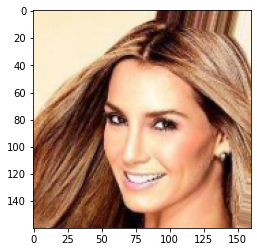

In [8]:
train_features, file_names = next(iter(celeba_dataloader))
print(f"Feature batch shape: {train_features.size()}")
img = transforms.ToPILImage()(train_features[0])
print(f'Filenanme: {file_names[0]}')
plt.imshow(img)
plt.show()

## Perfom MTCNN facial detection

Iterate through the DataLoader object and detect faces and associated detection probabilities for each. The MTCNN forward method returns images cropped to the detected face, if a face was detected. By default only a single detected face is returned - to have MTCNN return all detected faces, set keep_all=True when creating the MTCNN object above.

To obtain bounding boxes rather than cropped face images, you can instead call the lower-level mtcnn.detect() function. See help(mtcnn.detect) for details.

In [9]:
aligned = []
face_file_names = []

for x, y in zip(train_features, file_names):
    img = transforms.ToPILImage()(x)
    x_aligned, prob = mtcnn(img, return_prob=True)
    if x_aligned is not None:
        # print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        face_file_names.append(y)
    else: 
        print(f'No face detected for image: {y}')        

No face detected for image: 000120.jpg


In [10]:
# Get list of labels for the current batch
batch_labels = file_label_mapping[file_label_mapping['file_name'].isin(face_file_names)]['person_id'].to_numpy()

NameError: name 'file_label_mapping' is not defined

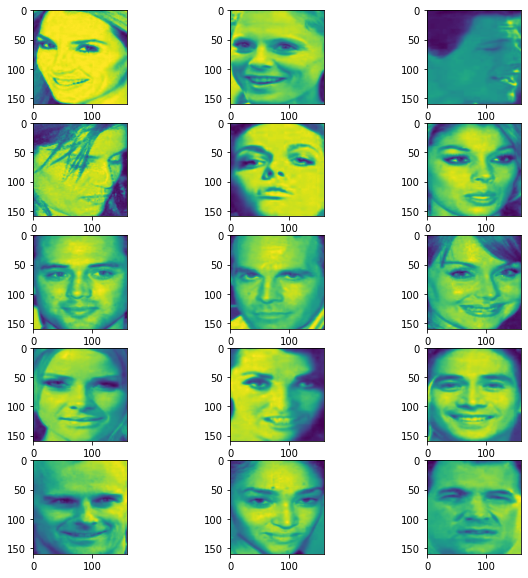

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=3)  # set up a 5x3 grid to visualize
image_crop_list = [x[0] for x in aligned]
for img, ax in zip(image_crop_list, axes.ravel()):
    ax.imshow(img)
plt.gcf().set_size_inches(10, 10)

## Calculate image embeddings

MTCNN will return images of faces all the same size, enabling easy batch processing with the Resnet recognition module. Here, since we only have a few images, we build a single batch and perform inference on it.

For real datasets, code should be modified to control batch sizes being passed to the Resnet, particularly if being processed on a GPU. For repeated testing, it is best to separate face detection (using MTCNN) from embedding or classification (using InceptionResnetV1), as calculation of cropped faces or bounding boxes can then be performed a single time and detected faces saved for future use.

In [11]:
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned)

## Print distance matrix for images

In [12]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
dists_df = pd.DataFrame(dists, columns=batch_labels, index=batch_labels)
dists_df = dists_df.loc[:,~dists_df.columns.duplicated()].copy()
dists_df

NameError: name 'batch_labels' is not defined

## Compare new Image

person_id: 5107
Face detected with probability: 0.999999


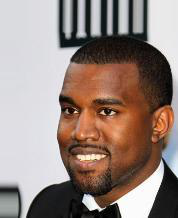

In [ ]:
# Open the image form working directory
test_image_file_name = '004635.jpg'
test_image = Image.open(f'data/{test_image_file_name}')

test_image_person_id = file_label_mapping[file_label_mapping['file_name'] == test_image_file_name]['person_id'].values[0]
print(f'person_id: {test_image_person_id}')

# Detect face in test image
aligned_test_image, prob = mtcnn(test_image, return_prob=True)
print('Face detected with probability: {:8f}'.format(prob))

test_image

In [ ]:
# Calculate Embeddings for Test Image
aligned_test_image = aligned_test_image.reshape([1] + list(aligned_test_image.shape)).to(device)
test_image_embedding = resnet(aligned_test_image)

In [ ]:
# Calculate Distances to Train Dataset
embeddings = embeddings.to(device)
dists = [(test_image_embedding - e1).norm().item() for e1 in embeddings]
dists_df = pd.DataFrame(dists, columns=['distance_to_test_image'], index=face_file_names)
dists_df = abs(dists_df - 1)

# Find closest embedding
display(dists_df[dists_df['test_image'] == dists_df['test_image'].min()])
closest_image = dists_df[dists_df['test_image'] == dists_df['test_image'].min()].index.values[0]

,test_image
000037.jpg,0.112285


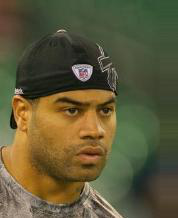

In [ ]:
# Open the closest image form working directory
closest_image = Image.open(f'img_align_celeba/{closest_image}')
closest_image

**The matching is clealy incorrect. This is because we only load in one batch of comparative data.**